In [27]:
import pandas as pd
import numpy as np
import itertools
import re
import nltk
from functools import partial
from sklearn.manifold import MDS
from matplotlib import pyplot as plt

In [28]:
comments = pd.read_csv('twitter_scrapped_final.csv',lineterminator='\n').drop(['Unnamed: 0'], axis=1).drop_duplicates(['text'])['text'].values
comments[0]

'Who you want to win in Pennsylvania? #Republicans #PennsylvaniaSenate #PrimaryDay'

In [29]:
Fetterman_list = ['johnfetterman', 'fetterman', 'fettermanforsenate', 'votefetterman', 'fettermanisthebetterman','fettermanforpa', 'giselefetterman','levifetterman','fettermanlt',
                'fetterwoman','fetterman2022','fettermania','fettermans', 'fettermandailymeme','fetter','votejohnfetterman','fettermen' ]
Oz_list = ['mehmetoz','mehmet', 'mehmetozthepuppymurderer', 'mehmetfromjersey', 'defundmehmetoz','snakeoilmehmetöz', 'mehmetozkillspuppies',
            'oz','voteoz','drozkillspuppies','droz','ooze','rejectoz','dogkilleroz','nooz','sendozhome','stopoz','ozisafraud','notooz', 'noozinpa', 'noonoz', 'voz',
            'votedroz', 'neveroz', 'ozfornj', 'saynotooz', 'ozzie', 'ozzy', 'realdoctorsagainstoz', 'ozforsenate', 'carpetbaggeroz', 'drozhitlercar', 'ozkillspuppies',
            'drozisafraud', 'ozisaquack', 'Dr. Oz', 'Dr Oz']

In [30]:
candidate_name_map = {"fetterman": Fetterman_list, "oz": Oz_list} 

# for word in Fetterman_list:
#     candidate_name_map[word] = "Fetterman"
# for word in Oz_list:
#     candidate_name_map[word] = "Oz"
# candidate_name_map

In [31]:
comment = comments[0]
print(comment)

Who you want to win in Pennsylvania? #Republicans #PennsylvaniaSenate #PrimaryDay


In [37]:
def get_lift_value(a_brand, b_brand, comments, candidate_name_map, attributes_flag=True):
    """
    returns the lift value for given two brands
    """
    n_a_b = 0
    n_a =0
    n_b =0
    i =0
    dummy = 0
    for comment in comments:
        n_a_tmp =0
        n_b_tmp =0
        if type(comment) == float:
            i = i+1
            continue
        else:
            if a_brand in comment.lower():
                n_a_tmp+=1
            if b_brand in comment.lower():
                n_b_tmp+=1
            word_set = [re.sub(r'[^\w]', ' ', word).strip().lower() for word in comment.split()]
            final_word_set = word_set.copy()
            final_word_set = [[re.sub(r'[^\w]', ' ', w).strip().lower()
                                                      for w in word.split()] for word in word_set if " " in word]
            final_word_set = list(set(list(itertools.chain.from_iterable(final_word_set))))
            final_word_set = list(set(word_set + final_word_set))
            if a_brand in candidate_name_map.keys():
                if set(final_word_set).intersection(set([a_brand] + candidate_name_map[a_brand])):
                    n_a_tmp+=1
            if set(final_word_set).intersection(set([a_brand])):
                n_a_tmp+=1
            if sum([1 for w in final_word_set if a_brand in w]):
                n_a_tmp+=1
            if b_brand in candidate_name_map.keys():
                if set(final_word_set).intersection(set([b_brand] + candidate_name_map[b_brand])):
                    n_b_tmp+=1
            if set(final_word_set).intersection(set([b_brand])):
                n_b_tmp+=1
            if sum([1 for w in final_word_set if b_brand in w]):
                n_b_tmp+=1                    
        if n_a_tmp>0:
            n_a = n_a + 1
        if n_b_tmp>0:
            n_b = n_b +1
        if n_a_tmp >0 and n_b_tmp > 0:
            n_a_b = n_a_b + 1
#     print(a_brand, b_brand, n_a, n_b, n_a_b)
    if n_a > 0 and n_b >0:
        return  (len(comments) - i) * (n_a_b / (n_a * n_b))
    else:
        return np.nan

In [38]:
# fixing the arguments comemnts and mis_brand_handle_t for function get_lift_value
get_lift_value_p = partial(get_lift_value, comments=comments, candidate_name_map = candidate_name_map)

In [39]:
%%time
lift_values = []
candidates_list = ["fetterman", "oz", "health", "abortion","gun", "security", "fraud", "crime"]
issue_list = ["fetterman", "oz", "health", "abortion","gun", "security", "fraud", "crime"]
# "Fetterman", "Oz", 
co_mentions_dict = {}
issues_lift_values = []
for cand in candidates_list:
    lift_value_tmp = []
    for iss in issue_list:
        lift= get_lift_value_p(cand, iss)
        lift_value_tmp.append(lift)
    issues_lift_values.append(lift_value_tmp)
issues_lift_values = pd.DataFrame(issues_lift_values, columns=issue_list, index=candidates_list)

CPU times: total: 53.3 s
Wall time: 58.4 s


In [40]:
issues_lift_values
# .to_csv('issue_lift_values.csv')

,fetterman,oz,health,abortion,gun,security,fraud,crime
fetterman,3.242206,1.635434,1.124313,0.949865,1.347297,1.374180,1.809057,1.298366
oz,1.635434,4.759057,1.202557,1.059634,0.714496,1.166127,2.689902,1.132590
health,1.124313,1.202557,73.803763,9.225470,1.187192,1.955067,1.871835,0.675549
abortion,0.949865,1.059634,9.225470,107.246094,1.725138,6.392151,0.777146,2.454144
gun,1.347297,0.714496,1.187192,1.725138,73.605898,0.487456,0.533376,2.358084
security,1.374180,1.166127,1.955067,6.392151,0.487456,181.821192,2.635090,2.080334
fraud,1.809057,2.689902,1.871835,0.777146,0.533376,2.635090,99.474638,0.682892
crime,1.298366,1.132590,0.675549,2.454144,2.358084,2.080334,0.682892,62.826087


In [41]:
for i in range(0, len(issues_lift_values)):
    issues_lift_values.iloc[i,i] = 1
issues_lift_values

,fetterman,oz,health,abortion,gun,security,fraud,crime
fetterman,1.000000,1.635434,1.124313,0.949865,1.347297,1.374180,1.809057,1.298366
oz,1.635434,1.000000,1.202557,1.059634,0.714496,1.166127,2.689902,1.132590
health,1.124313,1.202557,1.000000,9.225470,1.187192,1.955067,1.871835,0.675549
abortion,0.949865,1.059634,9.225470,1.000000,1.725138,6.392151,0.777146,2.454144
gun,1.347297,0.714496,1.187192,1.725138,1.000000,0.487456,0.533376,2.358084
security,1.374180,1.166127,1.955067,6.392151,0.487456,1.000000,2.635090,2.080334
fraud,1.809057,2.689902,1.871835,0.777146,0.533376,2.635090,1.000000,0.682892
crime,1.298366,1.132590,0.675549,2.454144,2.358084,2.080334,0.682892,1.000000


           fetterman        oz    health  abortion       gun  security  \
fetterman   1.000000  0.611458  0.889432  1.052781  0.742227  0.727707   
oz          0.611458  1.000000  0.831561  0.943722  1.399587  0.857540   
health      0.889432  0.831561  1.000000  1.000000  1.000000  1.000000   
abortion    1.052781  0.943722  1.000000  1.000000  1.000000  1.000000   
gun         0.742227  1.399587  1.000000  1.000000  1.000000  1.000000   
security    0.727707  0.857540  1.000000  1.000000  1.000000  1.000000   
fraud       0.552774  0.371761  1.000000  1.000000  1.000000  1.000000   
crime       0.770199  0.882932  1.000000  1.000000  1.000000  1.000000   

              fraud     crime  
fetterman  0.552774  0.770199  
oz         0.371761  0.882932  
health     1.000000  1.000000  
abortion   1.000000  1.000000  
gun        1.000000  1.000000  
security   1.000000  1.000000  
fraud      1.000000  1.000000  
crime      1.000000  1.000000  


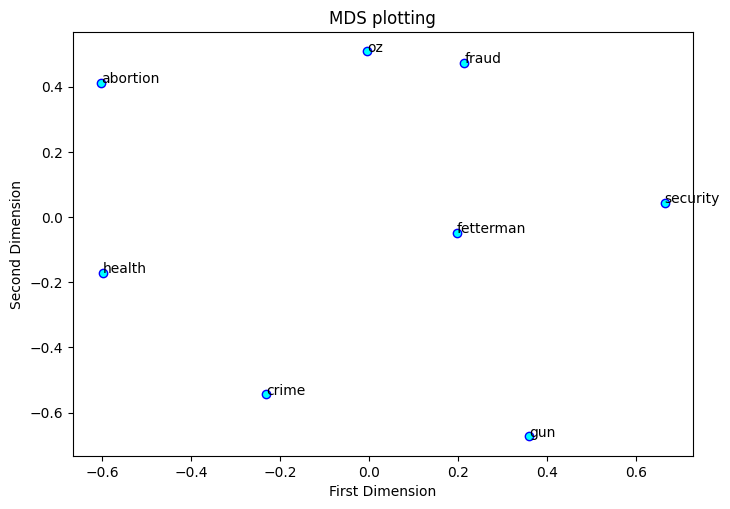

In [42]:
issues_lift_values_v2 = issues_lift_values.copy()
for i in range(0, len(issues_lift_values_v2)):
    for j in range(0, len(issues_lift_values_v2)):
            if i >= 2 and j >= 2:
                issues_lift_values_v2.iloc[i,j] = 1


diff_mat = 1/issues_lift_values_v2.iloc[:,:]
diff_mat
# for i in range(0, len(diff_mat.columns)):
#     diff_mat.iloc[i, i] =0
print(diff_mat)

mds_model = MDS(n_components = 2, random_state = 0, dissimilarity = 'precomputed')
mds_fit = mds_model.fit(diff_mat)  
mds_coords = mds_model.fit_transform(diff_mat)   

plt.rcParams["figure.figsize"] = (8,5.5)
plt.figure()
plt.scatter(mds_coords[:,0],mds_coords[:,1],
    facecolors = 'cyan', edgecolors = 'blue')
labels = diff_mat.columns
for label, x, y in zip(labels, mds_coords[:,0], mds_coords[:,1]):
    plt.annotate(label, (x,y), xycoords = 'data')
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('MDS plotting')    
plt.show()

In [43]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [44]:
def get_sentiment_score(candidate, issue, stop_words):
    relevant_comments = []
    for comment in comments:
        n_a_tmp = 0
        n_b_tmp = 0
        word_set = [re.sub(r'[^\w]', ' ', word).strip().lower() for word in comment.split()]
        final_word_set = word_set.copy()
        final_word_set = [[re.sub(r'[^\w]', ' ', w).strip().lower()
                                        for w in word.split()] for word in word_set if " " in word]
        final_word_set = list(set(list(itertools.chain.from_iterable(final_word_set))))
        final_word_set = list(set(word_set + final_word_set))
        if candidate in candidate_name_map.keys():
            if set(final_word_set).intersection(set([candidate] + candidate_name_map[candidate])):
                n_a_tmp+=1
        if set(final_word_set).intersection(set([candidate])):
            n_a_tmp+=1
        if sum([1 for w in final_word_set if candidate in w]):
            n_a_tmp+=1
        if set(final_word_set).intersection(set([issue])):
            n_b_tmp+=1
        if sum([1 for w in final_word_set if issue in w]):
            n_b_tmp+=1  
        if n_a_tmp >0 and n_b_tmp > 0:
            relevant_comments.append(comment)
            
            
    word_pair= []
    scores = []
    for line in relevant_comments:
        line_list = [re.sub(r'[^@\w]', ' ', word).strip().lower() for word in line.split()]
        new_line = []
        for word in line_list:
            if word in stop_words:
                continue
            new_line.append(word)
        try:
            idx = new_line.index(issue)
        except Exception as e:
            type(e)
            idx = [i for i in range(0, len(new_line)) if issue in new_line[i]][0]
        if idx + 2 < len(new_line) and idx - 2 >= 0:
            word_pair.append((new_line[idx-2] + " " + new_line[idx-1] + " " + new_line[idx] + " " +  new_line[idx+1] + " " +new_line[idx+2]))
        elif idx + 1 < len(new_line) and idx - 2 >= 0:
            word_pair.append((new_line[idx-2] + " " + new_line[idx-1] + " " + new_line[idx] + " " +  new_line[idx+1]))
        elif idx + 2 < len(new_line) and idx - 1 >= 0:
            word_pair.append((new_line[idx-1] + " " + new_line[idx] + " " + new_line[idx+1] + " " + new_line[idx+2]))           
        elif idx-2 >=0 and idx + 1  == len(new_line):
            word_pair.append((new_line[idx - 2] + " "+ new_line[idx - 1] + " " + new_line[idx] ))
        elif idx-1 >=0 and idx + 1  == len(new_line):
            word_pair.append((new_line[idx - 1] + " " + new_line[idx] ))
        elif idx == 0 and idx+2 < len(new_line):
            word_pair.append(( new_line[idx] + " " + new_line[idx + 1] + " " + new_line[idx + 2]))
        elif idx == 0 and idx+1 < len(new_line):
             word_pair.append(( new_line[idx] + " " + new_line[idx + 1]))
            

    new_words = {'health' : 0,
                 'abortion' : 0,
                 'gun' : 0, 
                 'security' : 0,
                 'fraud': 0,
                 'crime' : 0, 
                 'puppies' : 0,
                 'dog':0,
                 'black':0
        
    }
    analyzer = SentimentIntensityAnalyzer()
    analyzer.lexicon.update(new_words)
    for sentence in word_pair:
        score =  analyzer.polarity_scores(sentence)
        scores.append(score['compound'])
    return sum(scores) / len(scores)

In [47]:
%%time
sentiment_dict = {}
issues = ['health', 'abortion', 'gun', 'security', 'fraud', 'crime']
candidates = ['fetterman', 'oz']
for candidate in candidates:
    for issue in issues:
        if issues_lift_values.loc[candidate, issue] > 1:
            sentiment_dict[issue+ '_' + candidate] = get_sentiment_score(candidate, issue, stop_words)

CPU times: total: 7.75 s
Wall time: 8.28 s


In [48]:
candidate = 'fetterman'
f_keys = [key for key in sentiment_dict.keys() if candidate in key]
fetterman_df = pd.DataFrame(columns=['issue', 'lift', 'sentiment'])
for key in f_keys:
    values = [key.split('_')[0], issues_lift_values.loc[candidate,key.split('_')[0]], sentiment_dict[key]]
    fetterman_df = pd.concat([fetterman_df, pd.DataFrame([values], columns=['issue', 'lift', 'sentiment'])], axis=0)
fetterman_df

,issue,lift,sentiment
0,health,1.124313,0.095988
0,gun,1.347297,-0.005505
0,security,1.374180,-0.054848
0,fraud,1.809057,-0.053897
0,crime,1.298366,-0.080703


In [49]:
candidate = 'oz'
f_keys = [key for key in sentiment_dict.keys() if candidate in key]
oz_df = pd.DataFrame(columns=['issue', 'lift', 'sentiment'])
for key in f_keys:
    values = [key.split('_')[0], issues_lift_values.loc[candidate,key.split('_')[0]], sentiment_dict[key]]
    oz_df = pd.concat([oz_df, pd.DataFrame([values], columns=['issue', 'lift', 'sentiment'])], axis=0)
oz_df

,issue,lift,sentiment
0,health,1.202557,0.070617
0,abortion,1.059634,-0.176089
0,security,1.166127,-0.003284
0,fraud,2.689902,-0.088438
0,crime,1.132590,-0.048439


## Location Analysis

In [50]:
data=pd.read_csv('twitter_scrapped_final.csv').drop_duplicates(subset=['text'])
pa_cities = pd.read_csv('new_location_counts.csv')
pa_cities['location'].values[:7]

array(['Philadelphia', 'Oregon', 'Harrisburg', 'Cleveland', 'Pittsburgh',
       'Ohio', 'Berlin'], dtype=object)

In [51]:
data1=data[data['location'].isin(pa_cities['location'].values)]

In [52]:
top5_cities = ['Philadelphia','Pittsburgh','Allentown','Reading city','Erie','Philadelphia, PA','Pittsburgh, PA','Allentown, PA',
             'Philadelphia, PA, US','Erie, PA','Reading city, PA','Philadelphia, Pa.','PHILLY, PA','Erie, Pa.']
data1['location1'] = data1['location'].apply(lambda i: 'big_city' if i in top5_cities else 'small_city')
location_tweet=data1['location1'] + " " + data1['text']

C:\Users\shiva\AppData\Local\Temp\ipykernel_17068\1554734490.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['location1'] = data1['location'].apply(lambda i: 'big_city' if i in top5_cities else 'small_city')


In [54]:
%%time
city_lift_values = []
candidates_list = ["fetterman", "oz",]
cities = ["big_city", "small_city"]
# "Fetterman", "Oz", 
co_mentions_dict = {}
issues_lift_values = []
for cand in candidates_list:
    lift_value_tmp = []
    for city in cities:
        lift = get_lift_value(a_brand=cand, b_brand=city, comments=location_tweet, candidate_name_map=candidate_name_map)
        lift_value_tmp.append(lift)
    city_lift_values.append(lift_value_tmp)
city_lift_values = pd.DataFrame(city_lift_values, columns=cities, index=candidates_list)
city_lift_values

CPU times: total: 453 ms
Wall time: 521 ms


,big_city,small_city
fetterman,2.050120,0.701805
oz,1.951891,0.729698


## Location Sentiment Analysis

In [59]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import pandas as pd
import re
import string

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shiva\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [60]:
location_tweets_df = pd.DataFrame(location_tweet, columns=['tweets'])

In [72]:
small_city_comments = location_tweets_df[location_tweets_df['tweets'].str.contains("small_city")]['tweets']
big_city_comments = location_tweets_df[location_tweets_df['tweets'].str.contains("big_city")]['tweets']

In [73]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import itertools
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = list(set(stopwords.words('english')))
words = set(nltk.corpus.words.words())

def sentiment_on_comments(comments, candidate): 
    relevant_comments = []
    for comment in comments:
        n_a_tmp = 0
        word_set = [re.sub(r'[^\w]', ' ', word).strip().lower() for word in comment.split()]
        final_word_set = word_set.copy()
        final_word_set = [[re.sub(r'[^\w]', ' ', w).strip().lower()
                                        for w in word.split()] for word in word_set if " " in word]
        final_word_set = list(set(list(itertools.chain.from_iterable(final_word_set))))
        final_word_set = list(set(word_set + final_word_set))
        if candidate in candidate_name_map.keys():
            if set(final_word_set).intersection(set([candidate] + candidate_name_map[candidate])):
                n_a_tmp+=1
        if set(final_word_set).intersection(set([candidate])):
            n_a_tmp+=1
        if sum([1 for w in final_word_set if candidate in w]):
            n_a_tmp+=1
        if n_a_tmp >0:
            relevant_comments.append(comment)
    print("len of comments", len(relevant_comments))
    word_pair= []
    scores = []
    for line in relevant_comments:
        line_list = [re.sub(r'[^@\w]', ' ', word).strip().lower() for word in line.split()]
        new_line = []
        for word in line_list:
            if word in stop_words or (word not in candidate_name_map and word not in words):
                continue
            new_line.append(word)
            
        idx = [i for i in range(0, len(new_line)) if candidate in new_line[i]]

        for i in idx:
            l = i
            r = i
            l_cnt = 0
            r_cnt = 0
            
            pair = []
            
            while(l >= 0):
                if(l_cnt == 2) :break
                if(new_line[l] != candidate and candidate not in new_line[l] and new_line[l] not in candidate_name_map[candidate]):
                    pair.insert(0, new_line[l])
                    l_cnt += 1
                l -= 1
            
            pair.append(candidate)
            
            while(r < len(new_line)):
                if(r_cnt == 2) : break
                if(new_line[r] != candidate and candidate not in new_line[r] and new_line[r] not in candidate_name_map[candidate]):
                    pair.append(new_line[r])
                    r_cnt += 1
                r += 1
            
            if len(pair) != 0:
                sen =" ".join([str(i) for i in pair])
                word_pair.append(sen)
            

    new_words = {'big_city':0,
                 'small_city':0 
    }
    
    analyzer = SentimentIntensityAnalyzer()
    analyzer.lexicon.update(new_words)
    for sentence in word_pair:
        score =  analyzer.polarity_scores(sentence)
        scores.append(score['compound'])
    return sum(scores) / len(scores)

In [74]:
candidate_list = ["fetterman", "oz"] 
small_city_scores = {}
for candidate in candidate_list:
    small_city_scores[candidate] = sentiment_on_comments(small_city_comments, candidate)

len of comments 393
len of comments 287


In [75]:
small_city_scores

{'fetterman': 0.0700847457627119, 'oz': 0.018840594059405937}

In [76]:
candidate_list = ["fetterman", "oz"] 
big_city_scores = {}
for candidate in candidate_list:
    big_city_scores[candidate] = sentiment_on_comments(big_city_comments, candidate)
big_city_scores

len of comments 326
len of comments 218


{'fetterman': 0.056316923076923084, 'oz': 0.014393055555555555}